## Logistic Regression

Logistic regression is the process of estimating the **relationship** between **probability of a discreet event** and the independent variables or the regressors.

**Non-linear (Polynomial)** decision boundary can be captured by linear logistic model by adding nonlinear features. This is because the model is linear with respect to the parameters. 

**Regularization** is a method of controlling model complexity without removing features.

----
### Logistic Model (Linear decision boundary)

$$p_i=logistic\left(\sum_jx_{ij}\theta_j\right)$$
Where,
$$ logistic(z)=\frac{1}{1+e^{-z}} $$

|Symbol | Description |
| :---: | :--- |
| $p_i$ | Probability of an event occuring |
| $x_{ij}$ | Design matrix containing regressors of the training data |
| $\theta_j$ | Coefficients of the inner linear model |


In [1]:
clc
close all
clear all
format long
ver Octave

----------------------------------------------------------------------
GNU Octave Version: 7.1.0 (hg id: 04120d65778a)
GNU Octave License: GNU General Public License
Operating System: MINGW32_NT-6.2 Windows 6.2  x86_64
----------------------------------------------------------------------


### Nonlinear Features from initial regressors
Augments Design Matrix with nonlinear features based on initial regressors.

In [2]:
function X=countUP(X,base=2)
    X(1)=X(1)+1;
    for i=1:length(X)-1
        if(X(i)==base) 
            X(i)=0;
            X(i+1)=X(i+1)+1;
        endif
    endfor
    if(X(end)==base)
        X=zeros(size(X));
    endif
endfunction

function t=nlTerms(nv,o)
    count=1;
    L={};
    X=zeros(1,nv);
    X(1)=1;
    while sum(X)>0
        X=countUP(X,o+1);
        sX=sum(X);
        if(sX>o || sX<2)
            continue
        endif
        L(count)=X;
        count=count+1;
    endwhile
    t=reshape(cell2mat(L),nv,[])';
endfunction

function X=addNonlinearFeatures(X,order=5)
    nv=size(X,2)-1;
    m=size(X,1);
    T=nlTerms(nv,order);
    for i=1:size(T,1)
        f=ones(m,1);
        for j=1:nv
            if(T(i,j)~=0)
                f=f.*(X(:,j+1).^T(i,j));
            endif
        endfor
        X(:,end+1)=f;
    endfor
endfunction

### Hypothesis function (Binary Logistic Regression)

$$ f_\theta([X]_i)=logistic\left(\sum_jx_{ij}\theta_j\right)=\frac{1}{1+e^{-\left(\sum_jx_{ij}\theta_j\right)}} $$

In [3]:
function f=hypothesisFunction(X,theta)
    f=1./(1+exp(-X*theta));
endfunction

### Prediction function (Binary Logistic Regression)
Taking 0.5 as the threshold probability.

$$ g_\theta([X])=\begin{cases}
 & 1, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) \geq 0.5\\
 & 0, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) <  0.5
\end{cases}$$

In [4]:
function y=predictionFunction(X,theta,threshold=0.5)
    y=(hypothesisFunction(X,theta)>=threshold);
endfunction

### Cost Function and its gradient (Regularized)

$$\begin{aligned}
J([X],y,\theta) & = \frac{1}{m}\sum_{i=1}^m{cost(f_\theta([x]_i),y_i)}+\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
& = -\frac{1}{m}\sum_{i=1}^m{\left[y_ilog(f_\theta([x]_i))+(1-y_i)log(1-f_\theta([x]_i)) \right]} +\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
\nabla J([X],y,\theta)_{j=1} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}}  \\
\nabla J([X],y,\theta)_{j=2..n} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}} + \frac{\lambda}{m}\theta_j
\end{aligned}
$$
Where,
$$ cost(f_\theta([x]_i),y_i) = \begin{cases}
 & -log(f_\theta([x]_i)), &\text{ if } y_i = 1\\
 & -log(1-f_\theta([x]_i)), &\text{ if } y_i = 0
\end{cases}$$

In [5]:
function [J,gradJ]=costFunctionWithGrad(X,y,theta,lambda=0.1)
    h=hypothesisFunction(X,theta);
    m=length(y);
    J = 1/m*sum(-y.*log(h)-(1-y).*log(1-h))+lambda/2/m*sum(theta(2:end).^2);
    gradJ = 1/m*sum((h-y).*X)'+lambda/m*(theta-[theta(1);zeros(length(theta)-1,1)]);
endfunction

### Model parameter estimation
Minimizing cost by utilizing gradient information

In [6]:
function [f,theta,cost]=modelFit(X,y,initial_theta,lambda=0.1,max_iterations=400)
    options = optimset('GradObj', 'on', 'MaxIter', max_iterations, 'AutoScaling','on');
    [theta, cost] = fminunc(@(t)(costFunctionWithGrad(X, y, t,lambda)), initial_theta, options);
    f=@(X) predictionFunction(X,theta);
endfunction

### Plot Data

In [7]:
function plotData(X,y)
    d=size(X,2)-1;
    if d>3 || d==1
        disp("Cannot visualize higer dimensional data. Skipping.")
        return        
    endif 
    y1=find(y==1);
    y0=find(y==0);
    if d==2
        figure
        hold on
        scatter(X(y1,2),X(y1,3),"Filled");
        scatter(X(y0,2),X(y0,3),"Filled");
    else
        scatter3(X(y1,2),X(y1,3),X(y1,4),"Filled");
        hold on
        scatter3(X(y0,2),X(y0,3),X(y0,4),"Filled");
        zlabel('x3')
    endif
    xlabel('x1')
    ylabel('x2')
    title('Data')
    legend('Positive','Negative')
    hold off
endfunction

### Plot Decision Boundary
Contour or isosurface plot at value 0.5 for hypothesis function or Contour or isosurface plot at value 0 for the inner linear regression.

In [8]:
function plotDecisionBoundary(X,y,hFunction)
    d=size(X,2)-1;
    if d>3 || d==1
        disp("Cannot visualize higer dimensional data. Skipping.")
        return        
    endif 
    x_min=min(X);
    x_max=max(X);
    y1=find(y==1);
    y0=find(y==0);
    x1_gp=linspace(x_min(2),x_max(2),25);
    x2_gp=linspace(x_min(3),x_max(3),25);
    if d==2
        [x1,x2]=meshgrid(x1_gp,x2_gp);
        x1x2=[ones(numel(x1),1) x1(:) x2(:)];
        p_x1x2=hFunction(x1x2);
        p=reshape(p_x1x2,size(x1));
        figure
        hold on
        scatter(X(y1,2),X(y1,3),"Filled");
        scatter(X(y0,2),X(y0,3),"Filled");
        contour(x1,x2,p,[0.5 0.5]);
    else
        x3_gp=linspace(x_min(4),x_max(4),25);
        [x1,x2,x3]=meshgrid(x1_gp,x2_gp,x3_gp);
        x1x2x3=[ones(numel(x1),1) x1(:) x2(:) x3(:)];
        p_x1x2x3=hFunction(x1x2x3);
        p=reshape(p_x1x2x3,size(x1));
        scatter3(X(y1,2),X(y1,3),X(y1,4),"Filled");
        hold on
        scatter3(X(y0,2),X(y0,3),X(y0,4),"Filled");
        isosurface(x1,x2,x3,p,0.5);
        zlabel('x3')
    endif
    xlabel('x1')
    ylabel('x2')
    title('Decision Boundary')
    legend('Positive','Negative','Decision Boundary','location','bestoutside')
    hold off
endfunction

### Confusion Matrix
$$ \text{True Positive (TP) = Num. of True predictions where target is True} $$
$$ \text{True Negative (TN) = Num. of False predictions where target is False} $$
$$ \text{False Positive (FP) = Num. of True predictions where target is False} $$
$$ \text{False Negative (FN) = Num. of False predictions where target is True} $$

|  |(+) Prediction | (-) Prediction |
|:---:|:---:|:---:|
|(+) Actual | TP | FN |
|(-) Actual | FP | TN |



In [9]:
function C=ConfusionMatrix(p,t)
    TruePositive=sum(p==t & t==1);
    TrueNeagtive=sum(p==t & t==0);
    FalsePositive=sum(p~=t & t==0);
    FalseNegative=sum(p~=t & t==1);
    C=[TruePositive  , FalseNegative; 
       FalsePositive , TrueNeagtive];
endfunction

function printCell(c)
    printf ([sprintf("%%%is", max (cellfun (@numel, c))+8) "\n"], c'{:})
endfunction

function prettyprintConfusionMatrix(C)
    Z=cell(3);
    Z(1,1)="|";
    Z(1,2)="Pred. (+) |";
    Z(1,3)="Pred. (-) |";
    Z(2,1)="Actual (+) |";
    Z(3,1)="Actual (-) |";
    Z(2,2)=num2str(C(1,1),"%-8d |");
    Z(2,3)=num2str(C(1,2),"%-8d |");
    Z(3,2)=num2str(C(2,1),"%-8d |");
    Z(3,3)=num2str(C(2,2),"%-8d |");
    printCell(Z);
endfunction

### Main Program

Reads a csv file having last column as the target class and performs binary logistic regression analysis.

In [10]:
format short
[fname,fpath]=uigetfile("*.csv");
fileLoc=fullfile(fpath,fname);
Xy=csvread(fileLoc,1,0);
printf("First 10 entries in the file: %s\n",fname)
disp(Xy(1:10,:));
y=Xy(:,end);
X=[ones(length(y),1) Xy(:,1:end-1)];

First 10 entries in the file: Data_LogisticRegression_NonlinearBoundary_Xy.csv
    7.6000    4.0000         0
    2.1000    8.1000    1.0000
    8.5000    9.7000    1.0000
   10.0000    5.3000    1.0000
    1.3000    4.0000         0
    4.8000    7.3000         0
    2.0000    3.2000         0
    7.8000    4.2000         0
    1.6000    8.7000    1.0000
    7.7000    4.4000         0


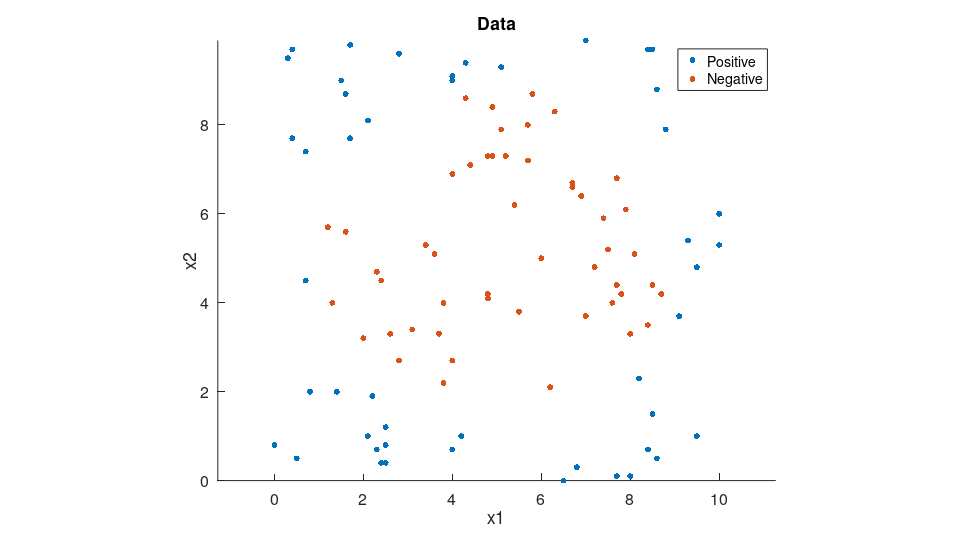

In [11]:
plotData(X,y)
axis('equal')

In [12]:
NV=size(X,2)-1;
X=addNonlinearFeatures(X,3);

In [13]:
initial_theta=zeros(size(X,2),1);
[fitM,theta,cost]=modelFit(X,y,initial_theta,lambda=10,max_iterations=10000);
C=ConfusionMatrix(fitM(X),y);
disp('Confusion Matrix:')
prettyprintConfusionMatrix(C);

Confusion Matrix:
                   |        Pred. (+) |        Pred. (-) |
        Actual (+) |         50       |         0        |
        Actual (-) |         0        |         50       |


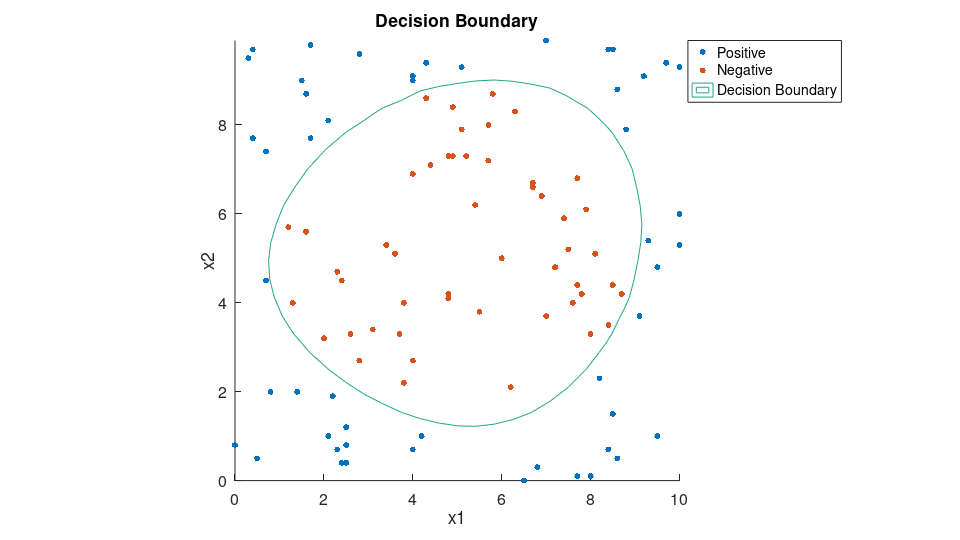

In [14]:
plotDecisionBoundary(X(:,1:NV+1),y,@(x) hypothesisFunction(addNonlinearFeatures(x,3),theta))
axis('equal')

In [15]:
printf("Cost = %g\n",cost)
disp("----------------------------")
disp("10th design point regressors:")
disp(X(10,1:NV+1))
printf("Predicted value of Dependent Variable = %g\n",fitM(X(10,:)))
printf("Target value of Dependent Variable = %g\n",y(10))

Cost = 0.092862
----------------------------
10th design point regressors:
   1.0000   7.7000   4.4000
Predicted value of Dependent Variable = 0
Target value of Dependent Variable = 0
